# Model Optimization Test - 양자화 인식 훈련

양자화 인식 훈련 적용

MNIST 데이터셋으로 실험

TFLite에서는 4가지의 양자화 유형을 지원함

1. 훈련 후 float16 양자화
2. 훈련 후 동적 범위 양자화
3. 훈련 후 정수 양자화
4. 양자화 인식 훈련

이번 노트북에서는 양자화 인식 훈련을 진행한 모델에 1, 2, 3을 적용하여 모델을  최적화 함.

float16, 동적 범위의 경우 추가적인 데이터가 필요하지 않지만, 정수 양자화의 경우 대표 샘플이 필요함.

Colab GPU에서 모델 훈련 후 Colab의 GPU에서 실험

# Setting

In [ ]:
!pip install -q tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 1.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import os
from pathlib import Path

import keras
import tensorflow as tf
import tensorflow_model_optimization as tfmot

from sklearn.metrics import accuracy_score

In [ ]:
# MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 1.0
test_images = test_images / 1.0

11490434/11490434 [==============================] - 2s 0us/step


# Base Model

## Train

In [ ]:
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_split=0.1,
)

1688/1688 [==============================] - 14s 7ms/step - loss: 1.0865 - accuracy: 0.9096 - val_loss: 0.1963 - val_accuracy: 0.9548


전체 모델에 양자화 인식 훈련 적용

In [ ]:
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLa  (None, 28, 28)            3         
 yer)                                                            
                                                                 
 quant_reshape (QuantizeWra  (None, 28, 28, 1)         1         
 pperV2)                                                         
                                                                 
 quant_conv2d (QuantizeWrap  (None, 26, 26, 12)        147       
 perV2)                                                          
                                                                 
 quant_max_pooling2d (Quant  (None, 13, 13, 12)        1         
 izeWrapperV2)                                                   
                                                                 
 quant_flatten (QuantizeWra  (None, 2028)              1

In [ ]:
train_images_subset = train_images[0:1000] # out of 60000
train_labels_subset = train_labels[0:1000]

# fine tuning
q_aware_model.fit(train_images_subset, train_labels_subset,
                  batch_size=500, epochs=1, validation_split=0.1)

2/2 [==============================] - 8s 1s/step - loss: 0.3129 - accuracy: 0.9189 - val_loss: 0.2235 - val_accuracy: 0.9400


In [ ]:
_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

_, q_aware_model_accuracy = q_aware_model.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)

Baseline test accuracy: 0.9477999806404114
Quant test accuracy: 0.9322999715805054


## Test

In [ ]:
Normal_Model_Acc_results = {
    'base_model': [],
    'tflite': [],
    'dynamic_quant': [],
    'float16_quant': [],
    'int_quant': []}

Normal_Model_Time_results = {
    'base_model': [],
    'tflite': [],
    'dynamic_quant': [],
    'float16_quant': [],
    'int_quant': []}

Q_Aware_Model_Acc_results = {
    'base_model': [],
    'tflite': [],
    'dynamic_quant': [],
    'float16_quant': [],
    'int_quant': []}

Q_Aware_Model_Time_results = {
    'base_model': [],
    'tflite': [],
    'dynamic_quant': [],
    'float16_quant': [],
    'int_quant': []}

In [ ]:
n_iter = 5

for iter in range(n_iter):
    start_time = time.time()

    y_pred = []

    for x in test_images:
        pred = np.argmax(model(np.expand_dims(x, axis=0).astype(np.float32)))
        y_pred.append(pred)

    Normal_Model_Acc_results['base_model'].append(accuracy_score(test_labels, y_pred))
    end_time = time.time()

    Normal_Model_Time_results['base_model'].append(end_time - start_time)

print('Normal Model Accuracy (GPU): %f' %(np.mean(Normal_Model_Acc_results['base_model'])))
print('Normal Model Inference Time (GPU): %f' %(np.mean(Normal_Model_Time_results['base_model'])))

Normal Model Accuracy (GPU): 0.947800
Normal Model Inference Time (GPU): 38.922454


In [ ]:
for iter in range(n_iter):
    start_time = time.time()

    y_pred = []

    for x in test_images:
        pred = np.argmax(q_aware_model(np.expand_dims(x, axis=0).astype(np.float32)))
        y_pred.append(pred)

    Q_Aware_Model_Acc_results['base_model'].append(accuracy_score(test_labels, y_pred))
    end_time = time.time()

    Q_Aware_Model_Time_results['base_model'].append(end_time - start_time)

print('Q-Aware Model Accuracy (GPU): %f' %(np.mean(Q_Aware_Model_Acc_results['base_model'])))
print('Q-Aware Model Inference Time (GPU): %f' %(np.mean(Q_Aware_Model_Time_results['base_model'])))

Q-Aware Model Accuracy (GPU): 0.932300
Q-Aware Model Inference Time (GPU): 71.149294


# 양자화 적용

## 일반 모델

In [ ]:
# TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_models_dir = Path("tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"base_model.tflite"
tflite_model_file.write_bytes(tflite_model)

84820

In [ ]:
# TFLite - Dynamic Quant
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_dynamic_quant_model = converter.convert()

tflite_model_dynamic_quant_file = tflite_models_dir/"dynamic_quant_model.tflite"
tflite_model_dynamic_quant_file.write_bytes(tflite_dynamic_quant_model)

24064

In [ ]:
# TFLite - Float16 Quant
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_float16_quant_model = converter.convert()

tflite_model_float16_quant_file = tflite_models_dir/"float16_quant_model.tflite"
tflite_model_float16_quant_file.write_bytes(tflite_float16_quant_model)

44624

In [ ]:
# TFLite - Int Quant
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images.astype(np.float32)).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_int_quant_model = converter.convert()

tflite_model_int_quant_file = tflite_models_dir/"int_quant_model.tflite"
tflite_model_int_quant_file.write_bytes(tflite_int_quant_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


24608

In [ ]:
interpreter_tflite = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter_tflite.allocate_tensors()

interpreter_dynamic = tf.lite.Interpreter(model_path=str(tflite_model_dynamic_quant_file))
interpreter_dynamic.allocate_tensors()

interpreter_f16 = tf.lite.Interpreter(model_path=str(tflite_model_float16_quant_file))
interpreter_f16.allocate_tensors()

interpreter_int = tf.lite.Interpreter(model_path=str(tflite_model_int_quant_file))
interpreter_int.allocate_tensors()

In [ ]:
# TFLite
input_index = interpreter_tflite.get_input_details()[0]["index"]
output_index = interpreter_tflite.get_output_details()[0]["index"]

for iter in range(n_iter):
    start_time = time.time()

    y_pred = []
    for x in test_images:
        x = np.expand_dims(x, axis=0).astype(np.float32)
        interpreter_tflite.set_tensor(input_index, x)

        interpreter_tflite.invoke()

        output = interpreter_tflite.tensor(output_index)
        pred = np.argmax(output()[0])
        y_pred.append(pred)

    Normal_Model_Acc_results['tflite'].append(accuracy_score(test_labels, y_pred))
    end_time = time.time()

    Normal_Model_Time_results['tflite'].append(end_time - start_time)

print('TFLite Accuracy (GPU): %f' %(np.mean(Normal_Model_Acc_results['tflite'])))
print('TFLite Inference Time (GPU): %f' %(np.mean(Normal_Model_Time_results['tflite'])))

TFLite Accuracy (GPU): 0.947800
TFLite Inference Time (GPU): 1.351541


In [ ]:
# TFLite - Dynamic Quantization
input_index = interpreter_dynamic.get_input_details()[0]["index"]
output_index = interpreter_dynamic.get_output_details()[0]["index"]

for iter in range(n_iter):
    start_time = time.time()

    y_pred = []
    for x in test_images:
        x = np.expand_dims(x, axis=0).astype(np.float32)
        interpreter_dynamic.set_tensor(input_index, x)

        interpreter_dynamic.invoke()

        output = interpreter_dynamic.tensor(output_index)
        pred = np.argmax(output()[0])
        y_pred.append(pred)

    Normal_Model_Acc_results['dynamic_quant'].append(accuracy_score(test_labels, y_pred))
    end_time = time.time()

    Normal_Model_Time_results['dynamic_quant'].append(end_time - start_time)

print('Dynamic Quant Accuracy (GPU): %f' %(np.mean(Normal_Model_Acc_results['dynamic_quant'])))
print('Dynamic Quant Inference Time (GPU): %f' %(np.mean(Normal_Model_Time_results['dynamic_quant'])))

Dynamic Quant Accuracy (GPU): 0.947700
Dynamic Quant Inference Time (GPU): 1.029758


In [ ]:
# TFLite - Float16 Quantization
input_index = interpreter_f16.get_input_details()[0]["index"]
output_index = interpreter_f16.get_output_details()[0]["index"]

for iter in range(n_iter):
    start_time = time.time()

    y_pred = []
    for x in test_images:
        x = np.expand_dims(x, axis=0).astype(np.float32)
        interpreter_f16.set_tensor(input_index, x)

        interpreter_f16.invoke()

        output = interpreter_f16.tensor(output_index)
        pred = np.argmax(output()[0])
        y_pred.append(pred)

    Normal_Model_Acc_results['float16_quant'].append(accuracy_score(test_labels, y_pred))
    end_time = time.time()

    Normal_Model_Time_results['float16_quant'].append(end_time - start_time)

print('Float16 Accuracy (GPU): %f' %(np.mean(Normal_Model_Acc_results['float16_quant'])))
print('Float16 Inference Time (GPU): %f' %(np.mean(Normal_Model_Time_results['float16_quant'])))

Float16 Accuracy (GPU): 0.948000
Float16 Inference Time (GPU): 1.086174


In [ ]:
# TFLite - Int Quantization
input_index = interpreter_int.get_input_details()[0]["index"]
output_index = interpreter_int.get_output_details()[0]["index"]

for iter in range(n_iter):
    start_time = time.time()

    y_pred = []
    for x in test_images:
        x = np.expand_dims(x, axis=0).astype(np.uint8)
        interpreter_int.set_tensor(input_index, x)

        interpreter_int.invoke()

        output = interpreter_int.tensor(output_index)
        pred = np.argmax(output()[0])
        y_pred.append(pred)

    Normal_Model_Acc_results['int_quant'].append(accuracy_score(test_labels, y_pred))
    end_time = time.time()

    Normal_Model_Time_results['int_quant'].append(end_time - start_time)

print('Int Quant Accuracy (GPU): %f' %(np.mean(Normal_Model_Acc_results['int_quant'])))
print('Int QuantInference Time (GPU): %f' %(np.mean(Normal_Model_Time_results['int_quant'])))

Int Quant Accuracy (GPU): 0.947200
Int QuantInference Time (GPU): 0.912520


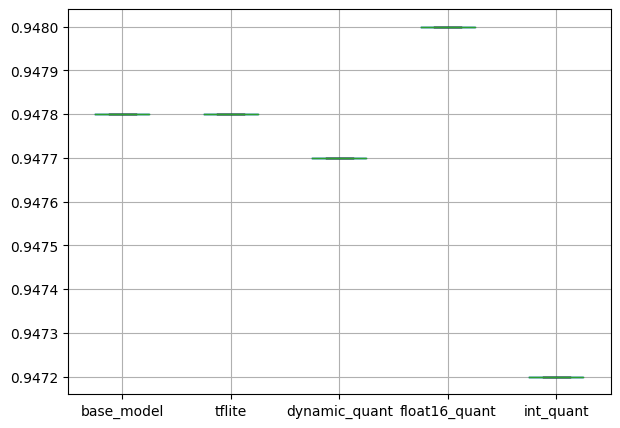

In [ ]:
pd.DataFrame(Normal_Model_Acc_results).boxplot(figsize=(7, 5))
plt.show()

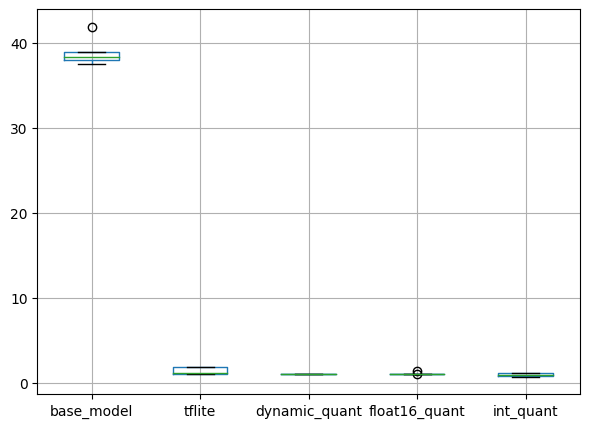

In [ ]:
pd.DataFrame(Normal_Model_Time_results).boxplot(figsize=(7, 5))
plt.show()

## 양자화 인식 훈련 모델

In [ ]:
# TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
tflite_model = converter.convert()

# Q-Aware Model
tflite_models_dir = Path("tflite_q_aware_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"base_model.tflite"
tflite_model_file.write_bytes(tflite_model)

88000

In [ ]:
# TFLite - Dynamic Quant
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_dynamic_quant_model = converter.convert()

tflite_model_dynamic_quant_file = tflite_models_dir/"dynamic_quant_model.tflite"
tflite_model_dynamic_quant_file.write_bytes(tflite_dynamic_quant_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


25120

In [ ]:
# TFLite - Float16 Quant
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_float16_quant_model = converter.convert()

tflite_model_float16_quant_file = tflite_models_dir/"float16_quant_model.tflite"
tflite_model_float16_quant_file.write_bytes(tflite_float16_quant_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


25120

In [ ]:
# TFLite - Int Quant
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images.astype(np.float32)).batch(1).take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_int_quant_model = converter.convert()

tflite_model_int_quant_file = tflite_models_dir/"int_quant_model.tflite"
tflite_model_int_quant_file.write_bytes(tflite_int_quant_model)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


25128

In [ ]:
interpreter_tflite = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter_tflite.allocate_tensors()

interpreter_dynamic = tf.lite.Interpreter(model_path=str(tflite_model_dynamic_quant_file))
interpreter_dynamic.allocate_tensors()

interpreter_f16 = tf.lite.Interpreter(model_path=str(tflite_model_float16_quant_file))
interpreter_f16.allocate_tensors()

interpreter_int = tf.lite.Interpreter(model_path=str(tflite_model_int_quant_file))
interpreter_int.allocate_tensors()

In [ ]:
# TFLite
input_index = interpreter_tflite.get_input_details()[0]["index"]
output_index = interpreter_tflite.get_output_details()[0]["index"]

for iter in range(n_iter):
    start_time = time.time()

    y_pred = []
    for x in test_images:
        x = np.expand_dims(x, axis=0).astype(np.float32)
        interpreter_tflite.set_tensor(input_index, x)

        interpreter_tflite.invoke()

        output = interpreter_tflite.tensor(output_index)
        pred = np.argmax(output()[0])
        y_pred.append(pred)

    Q_Aware_Model_Acc_results['tflite'].append(accuracy_score(test_labels, y_pred))
    end_time = time.time()

    Q_Aware_Model_Time_results['tflite'].append(end_time - start_time)

print('TFLite Accuracy (GPU): %f' %(np.mean(Q_Aware_Model_Acc_results['tflite'])))
print('TFLite Inference Time (GPU): %f' %(np.mean(Q_Aware_Model_Time_results['tflite'])))

TFLite Accuracy (GPU): 0.932400
TFLite Inference Time (GPU): 1.093805


In [ ]:
# TFLite - Dynamic Quantization
input_index = interpreter_dynamic.get_input_details()[0]["index"]
output_index = interpreter_dynamic.get_output_details()[0]["index"]

for iter in range(n_iter):
    start_time = time.time()

    y_pred = []
    for x in test_images:
        x = np.expand_dims(x, axis=0).astype(np.float32)
        interpreter_dynamic.set_tensor(input_index, x)

        interpreter_dynamic.invoke()

        output = interpreter_dynamic.tensor(output_index)
        pred = np.argmax(output()[0])
        y_pred.append(pred)

    Q_Aware_Model_Acc_results['dynamic_quant'].append(accuracy_score(test_labels, y_pred))
    end_time = time.time()

    Q_Aware_Model_Time_results['dynamic_quant'].append(end_time - start_time)

print('Dynamic Quant Accuracy (GPU): %f' %(np.mean(Q_Aware_Model_Acc_results['dynamic_quant'])))
print('Dynamic Quant Inference Time (GPU): %f' %(np.mean(Q_Aware_Model_Time_results['dynamic_quant'])))

Dynamic Quant Accuracy (GPU): 0.932400
Dynamic Quant Inference Time (GPU): 0.727844


In [ ]:
# TFLite - Float16 Quantization
input_index = interpreter_f16.get_input_details()[0]["index"]
output_index = interpreter_f16.get_output_details()[0]["index"]

for iter in range(n_iter):
    start_time = time.time()

    y_pred = []
    for x in test_images:
        x = np.expand_dims(x, axis=0).astype(np.float32)
        interpreter_f16.set_tensor(input_index, x)

        interpreter_f16.invoke()

        output = interpreter_f16.tensor(output_index)
        pred = np.argmax(output()[0])
        y_pred.append(pred)

    Q_Aware_Model_Acc_results['float16_quant'].append(accuracy_score(test_labels, y_pred))
    end_time = time.time()

    Q_Aware_Model_Time_results['float16_quant'].append(end_time - start_time)

print('Float16 Accuracy (GPU): %f' %(np.mean(Q_Aware_Model_Acc_results['float16_quant'])))
print('Float16 Inference Time (GPU): %f' %(np.mean(Q_Aware_Model_Time_results['float16_quant'])))

Float16 Accuracy (GPU): 0.932400
Float16 Inference Time (GPU): 0.735955


In [ ]:
# TFLite - Int Quantization
input_index = interpreter_int.get_input_details()[0]["index"]
output_index = interpreter_int.get_output_details()[0]["index"]

for iter in range(n_iter):
    start_time = time.time()

    y_pred = []
    for x in test_images:
        x = np.expand_dims(x, axis=0).astype(np.uint8)
        interpreter_int.set_tensor(input_index, x)

        interpreter_int.invoke()

        output = interpreter_int.tensor(output_index)
        pred = np.argmax(output()[0])
        y_pred.append(pred)

    Q_Aware_Model_Acc_results['int_quant'].append(accuracy_score(test_labels, y_pred))
    end_time = time.time()

    Q_Aware_Model_Time_results['int_quant'].append(end_time - start_time)

print('Int Quant Accuracy (GPU): %f' %(np.mean(Q_Aware_Model_Acc_results['int_quant'])))
print('Int QuantInference Time (GPU): %f' %(np.mean(Q_Aware_Model_Time_results['int_quant'])))

Int Quant Accuracy (GPU): 0.932400
Int QuantInference Time (GPU): 0.941354


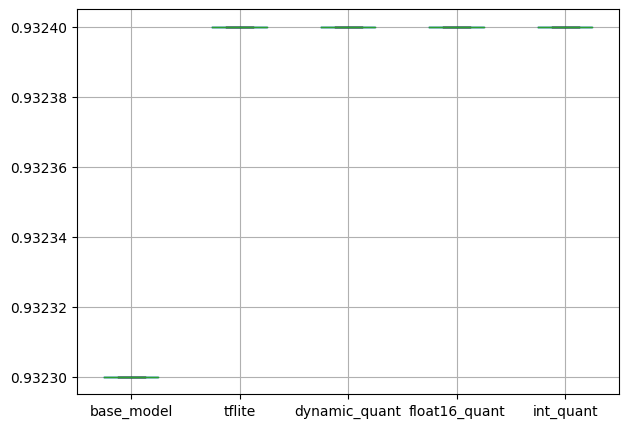

In [ ]:
pd.DataFrame(Q_Aware_Model_Acc_results).boxplot(figsize=(7, 5))
plt.show()

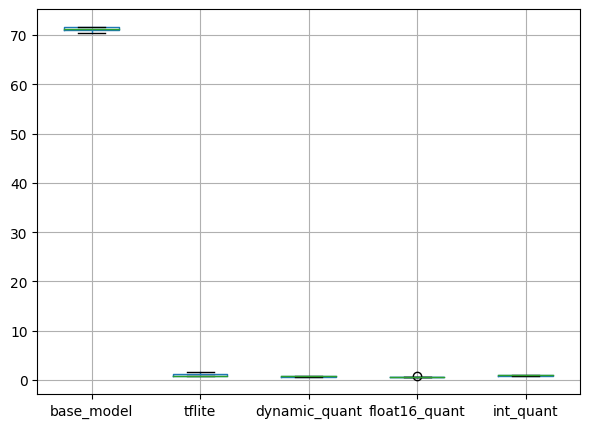

In [ ]:
pd.DataFrame(Q_Aware_Model_Time_results).boxplot(figsize=(7, 5))
plt.show()

# 모델 크기

In [ ]:
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

In [ ]:
tflite_size = os.path.getsize('/content/tflite_models/base_model.tflite')
dynamic_quant_size = os.path.getsize('/content/tflite_models/dynamic_quant_model.tflite')
float16_quant_size = os.path.getsize('/content/tflite_models/float16_quant_model.tflite')
int_quant_size = os.path.getsize('/content/tflite_models/int_quant_model.tflite')

print('Normal Model')
print('TFLite Size:', convert_size(tflite_size), 'bytes')
print('Dynamic Quant Size:', convert_size(dynamic_quant_size), 'bytes')
print('Float16 Quant Size:', convert_size(float16_quant_size), 'bytes')
print('Int Quant Size:', convert_size(int_quant_size), 'bytes')

Normal Model
TFLite Size: 82.83 KB bytes
Dynamic Quant Size: 23.5 KB bytes
Float16 Quant Size: 43.58 KB bytes
Int Quant Size: 24.03 KB bytes


In [ ]:
tflite_size = os.path.getsize('/content/tflite_q_aware_models/base_model.tflite')
dynamic_quant_size = os.path.getsize('/content/tflite_q_aware_models/dynamic_quant_model.tflite')
float16_quant_size = os.path.getsize('/content/tflite_q_aware_models/float16_quant_model.tflite')
int_quant_size = os.path.getsize('/content/tflite_q_aware_models/int_quant_model.tflite')

print('Q-Aware Model')
print('TFLite Size:', convert_size(tflite_size), 'bytes')
print('Dynamic Quant Size:', convert_size(dynamic_quant_size), 'bytes')
print('Float16 Quant Size:', convert_size(float16_quant_size), 'bytes')
print('Int Quant Size:', convert_size(int_quant_size), 'bytes')

Q-Aware Model
TFLite Size: 85.94 KB bytes
Dynamic Quant Size: 24.53 KB bytes
Float16 Quant Size: 24.53 KB bytes
Int Quant Size: 24.54 KB bytes
